## Fichier pour l'optimisation des bandes de Bollinguer 

#### Import des Fichiers nécéssaires 

In [24]:
# Le nécéssaire pour les algorithmes génétiques 
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
#fichier sujet de l'optimisation 
from _bollinger_bands import BollingerBands
#Data Analysis 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
data=pd.read_csv("MASI.csv",parse_dates=True, index_col=0)

In [5]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,0,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,0,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,0,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,0,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,0,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,0,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,0,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,0,MAD


In [6]:
df=data["Close"]
high=data["High"]
low=data["Low"]


## Fonction

In [7]:
premier=0 

In [8]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [9]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

In [10]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [11]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
            
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

In [12]:
from _bollinger_bands import BollingerBands

In [13]:
BB=BollingerBands(data)

In [14]:
BB._calculateTi(period=12,std_number=4)

,middle_band,upper_band,lower_band
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN
...,...,...,...
2022-03-28,12719.239167,13215.1292,12223.3491
2022-03-29,12727.359167,13209.7997,12244.9187
2022-03-30,12735.048333,13210.8412,12259.2555


In [15]:
def obj_bollinger(period):
    global std_number 
    period=int(period[0])
    signal=pd.DataFrame(index=df.index)
    signal["compa"]=np.nan
    signal["compa2"]=np.nan
    bb=BB._calculateTi(period,std_number)[["upper_band","lower_band"]]
    #bb=at.bollinger(df,n,k)[["BBDOWN","BBUP"]]
    signal["compa"][period:] = np.where( (df[period:] > bb["upper_band"][period:] ) ,1,0)
    signal["compa2"][period:] = np.where( (df[period:] < bb["lower_band"][period:] ) ,4,2)
    signal["signal"]=signal["compa"].diff()
    signal["signal2"]=signal["compa2"].diff()
    sig=np.where(signal["signal"]==1,-1,0)+np.where(signal["signal2"]==2,1,0)
    sig=adjustsignal(sig)
    sig=pd.Series(sig, index=df.index)
    cours=df*(1+taux*sig)
    pmval=pmv(cours,sig)
    return pmval.max(),

gen	nevals	max    	avg    
0  	40    	18116.6	10417.9
1  	36    	18116.6	13488.2
2  	40    	18116.6	15235.1
3  	38    	18116.6	16936.2
4  	40    	18116.6	17932.1
5  	38    	18116.6	17605.6
Hall of Fame Individuals = 
[37.003472312614505]
[37.996527687385495]
[37.08448080193734]
[37]
[38]
Best Ever Individual =  [37]


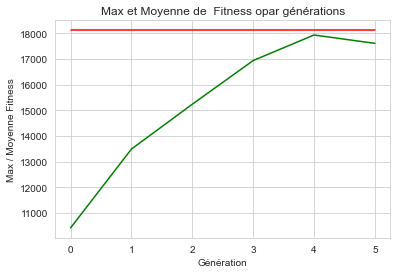

In [16]:
std_number=3 
GeneticAlgo(1,obj_bollinger,5,20,60)

gen	nevals	max    	avg    
0  	40    	22554.2	10092.3
1  	36    	22554.2	16513.9
2  	38    	22554.2	19800.3
3  	35    	22554.2	21937.9
4  	38    	22554.2	22102.4
5  	33    	22554.2	22554.2
Hall of Fame Individuals = 
[23.010252205002143]
[23.000002290052183]
[23.010254495054326]
[23.048704833394627]
[23]
Best Ever Individual =  [23]


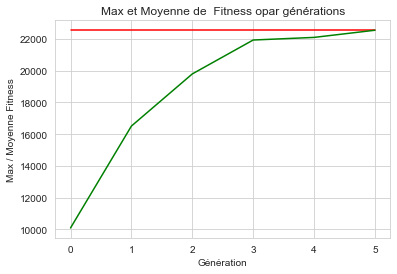

In [17]:

std_number=2.5
GeneticAlgo(1,obj_bollinger,5,20,60)

In [18]:
BB._calculateTi(period=12,std_number=4)

,middle_band,upper_band,lower_band
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN
...,...,...,...
2022-03-28,12719.239167,13215.1292,12223.3491
2022-03-29,12727.359167,13209.7997,12244.9187
2022-03-30,12735.048333,13210.8412,12259.2555


In [19]:
df=data

In [20]:
df=pd.DataFrame(df)

In [21]:
df

,open,high,low,close,volume,currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,0,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,0,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,0,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,0,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,0,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,0,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,0,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,0,MAD


## Test

In [22]:
import BVCscrap  as load

In [23]:
import BVCscrap  as load
data_bcp=load.loadata('BCP')
data_bcp.to_csv("data_bcp.csv")

JSONDecodeError: Expecting value: line 4 column 1 (char 4)

In [ ]:
data_bcp=pd.read_csv("data_bcp.csv",parse_dates=True, index_col=0)

In [ ]:
df=data_bcp["Value"]

In [ ]:
df=pd.DataFrame(df)


Simulation Data:
            signal open_trading_action stock_value exposure portfolio_value  \
Date                                                                         
2018-01-02   hold                none    12420.15      0.0             0.0   
2018-01-03   hold                none    12509.58      0.0             0.0   
2018-01-04   hold                none    12463.08      0.0             0.0   
2018-01-05   hold                none    12537.75      0.0             0.0   
2018-01-08   hold                none    12479.42      0.0             0.0   
...           ...                 ...         ...      ...             ...   
2022-03-28   hold                none    12640.22      0.0             0.0   
2022-03-29   hold                none    12721.38      0.0             0.0   
2022-03-30   hold                none    12751.45      0.0             0.0   
2022-03-31   hold                none    12818.11      0.0             0.0   
2022-04-01   hold                none    1284

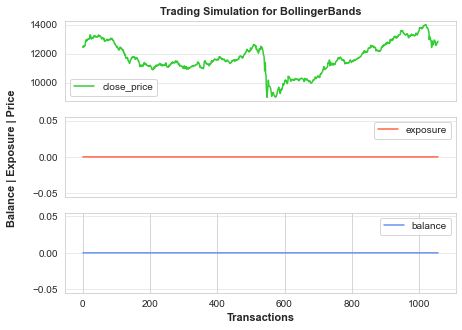

In [ ]:
simulation_data, simulation_statistics, simulation_graph = \
BB.getTiSimulation(close_values=df, max_exposure=None,short_exposure_factor=1.5)
print('\nSimulation Data:\n', simulation_data)
print('\nSimulation Statistics:\n', simulation_statistics)


In [ ]:
BB._calculateTi(period=12,std_number=4)

,middle_band,upper_band,lower_band
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN
...,...,...,...
2022-03-28,12719.239167,13215.1292,12223.3491
2022-03-29,12727.359167,13209.7997,12244.9187
2022-03-30,12735.048333,13210.8412,12259.2555
